# Movie Recommendation

This system is a topic of machine learning. I have incorporated several contents we have learned into this code：

1. Data analyzing
2. Data visualization
3. Data predicting

And I learned:

1. Content-based filtering
2. Matrix
3. Cosine similarity

## Import packages

In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno # offers many functions using which you can plot different graphs to visualize the missing values data

## Read the Data

In [178]:
data = pd.read_csv('file:///Users/sujian/Downloads/netflix.csv')
print('The shape of data:',data.shape)
data.head()

The shape of data: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## Visualizing the Data

### The first image shows whether every movie contains all features

29.91% of movies missing the feature director
9.37% of movies missing the feature cast
9.44% of movies missing the feature country


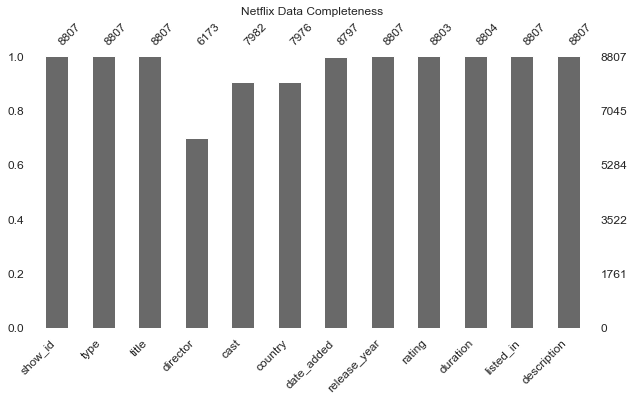

In [180]:
msno.bar(data, figsize=(10,5), fontsize=12)
plt.title("Netflix Data Completeness")
miss_director = format((8807 - 6173) / 8807,'.2%')
miss_cast = format((8807 - 7982) / 8807,'.2%')
miss_country = format((8807 - 7976) / 8807,'.2%')
print(miss_director,'of movies missing the feature director')
print(miss_cast,'of movies missing the feature cast')
print(miss_country,'of movies missing the feature country')

### The second image shows the percentage of the two broadcast forms

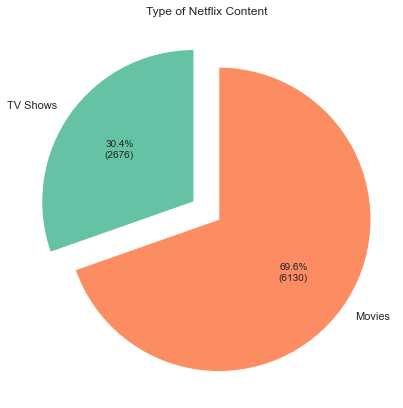


 The dataset consists of 2676 TV Shows and 6131 Movies


In [181]:
labels = ['TV Shows', 'Movies']
plt.figure(figsize=(14, 7))
plt.pie(data['type'].value_counts().sort_values(), colors = colors, labels = labels, autopct = lambda pct: func(pct, data['type'].value_counts().sort_values()), explode=[0.1,0.1], startangle=90)
# data['type'].value_counts().sort_values(), labels = labels, autopct = '%.2f%%', colors = colors, explode=[0.1,0.1], startangle=90
plt.title("Type of Netflix Content")
plt.show()
print("\n The dataset consists of 2676 TV Shows and 6131 Movies")

### The third image shows the number of film and television works that broadcast in different years

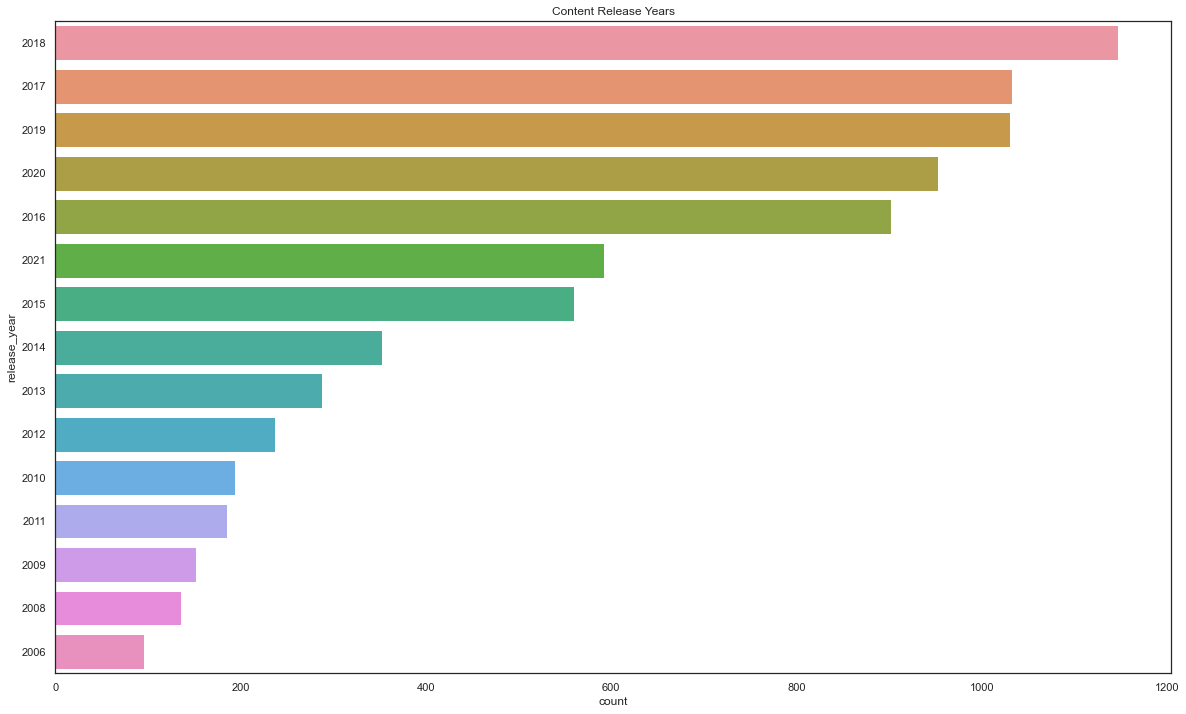

In [182]:
plt.figure(figsize=(20,12))
sns.countplot(y="release_year", data=data, order=data['release_year'].value_counts().index[0:15])
plt.title("Content Release Years");

### The last image shows the number of different types of content rating

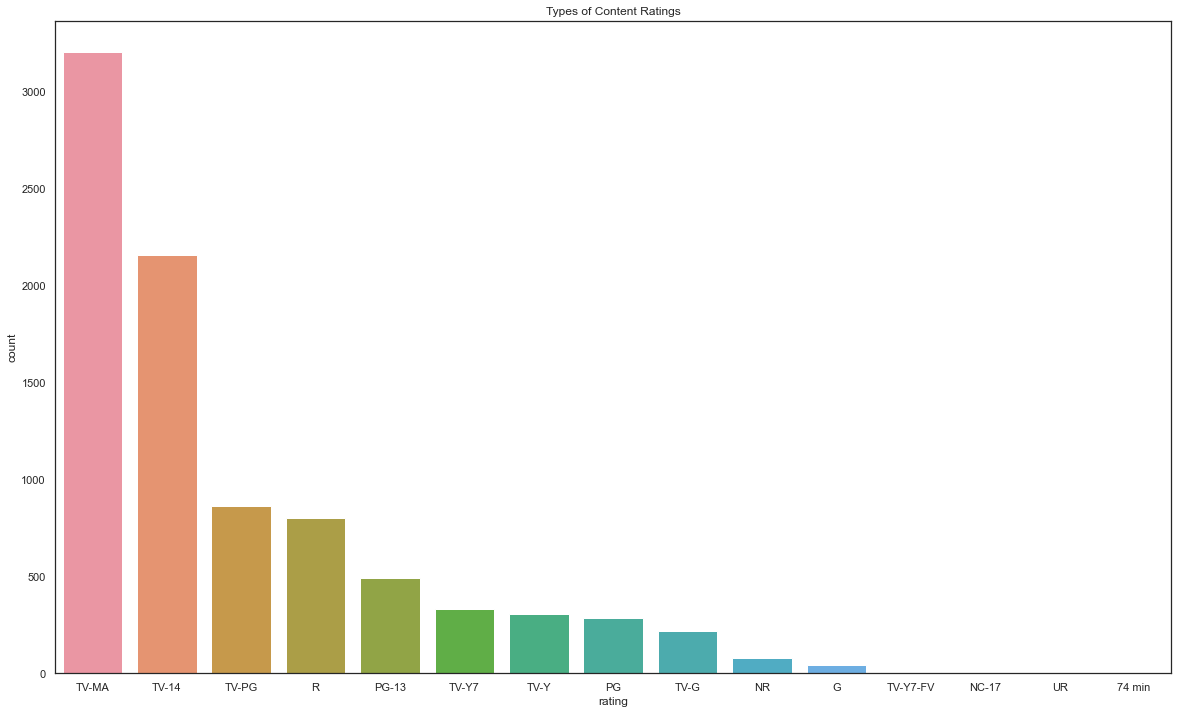

In [183]:
plt.figure(figsize=(20,12))
sns.countplot(x="rating", data=data, order=data['rating'].value_counts().index[0:15]);
plt.title("Types of Content Ratings");
plt.show();

## Droping Unnecessary Features
My recommendation system only contains director, cast, country, rating and genre. Using for loop to drop unnecessary feature. 

In [184]:
for col in ['show_id', 'date_added', 'release_year', 'duration']:
    data.drop(col, axis=1, inplace=True)

## Creating a Feature Matrix
The example uses csr_matrix method in scipy.sparse to transform the data to a matrix

But I created a matrix by hand referring to ndarray. I insert data into the matrix through array and dictionary. 

In [185]:
def creat_matrix(feature_column) ->  np.ndarray:
    
    """
    ex: pass in data['director'], to get a matrix (#allmovies, #alldirectors)
    """
    
    isNan = False
    feature_list = []
    for items in feature_column:
        if pd.isna(items):
            feature_list.append(['']) #place holder for nan values
            isNan = True
        else:
            item_list = re.split(r', \s*', items)
            feature_list.append(item_list)
        
    flatten_features_list = [item for sublist in feature_list for item in sublist]
    unique_features = list(np.unique(flatten_features_list))

    if isNan == True: # check if Nan value was passed through.
        unique_features = unique_features[1:] # '' is at index 0. This removes that value from list. 
                                              # Or return data from the second to the last
    
    index = {} # key: feature's name  value: column index
    for i, name in enumerate(unique_features):
        index[name] = i

    matrix = np.zeros((feature_column.shape[0], len(unique_features))) # creat a matrix of zero(#movies, #unique features)
    for i, items in enumerate(feature_list): # update feature matrix with 1.0 where a movie has a particular feature. i.e specific director or actor. 
        movie = np.zeros(len(unique_features)) # movie array with all 0's
        if len(items) > 1:
            for item in items:
                if item != '': # this line of code ignores empty strings with in features that that are not null but have empty strings in the category. ex: ['', 'France']
                    movie[index[item]] = 1.0
            matrix[i] = movie
        elif items == ['']:
            matrix[i] = movie
        else:
            movie[index[items[0]]] = 1.0
            matrix[i] = movie
    return matrix

We will find the movie feature matrixes for each category and then combine them to make one giant matrix.

In [186]:
movie_director = creat_matrix(data['director'])
movie_cast = creat_matrix(data['cast'])
movie_country = creat_matrix(data['country'])
movie_rating = creat_matrix(data['rating'])
movie_genre = creat_matrix(data['listed_in'])
feature_matrix = np.concatenate((movie_director, movie_cast, movie_country, movie_rating, movie_genre), axis = 1)
print(f'Movie Feature Matrix shape: {feature_matrix.shape}')
print(feature_matrix)

Movie Feature Matrix shape: (8807, 41617)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Cosine Similarity
$$\text{cosine similarity} =S_C (A,B):= \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

The Cosine Similarity measures the similarity between two sequences of numbers by viewing each vector in an inner product space, and the cosine similarity is defined as the cosine of the angle between them. The dot product of the vectors divided by the product of their lengths.


In [203]:
from numpy.linalg import norm
def cosine(feature_matrix) -> np.ndarray:

    cos_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T
    
    cosine = np.dot(a,b)/(norm(a)*norm(b))
    return cosine

The example uses NearestNeighbors from sklearn, but I used numpy instead

# Generating Movie Similarity Matrix
The matrix contains the similarity rate between two different movies. Where the max value between a movie is 1, meaning both movies are identical or 0 meaning they are completely different.

In [198]:
similarity = cosine(feature_matrix)

In [199]:
print(f'Shape: {cosine_similarity.shape} \n {cosine_similarity}')

Shape: (8807, 8807) 
 [[1.         0.         0.         ... 0.14433757 0.13363062 0.        ]
 [0.         1.         0.10910895 ... 0.         0.         0.        ]
 [0.         0.10910895 1.         ... 0.         0.         0.        ]
 ...
 [0.14433757 0.         0.         ... 1.         0.15430335 0.        ]
 [0.13363062 0.         0.         ... 0.15430335 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [209]:
def getRecommandation(title, matrix):
    if title in list(data['title']):
        movie_index = pd.Series(data.index, index= data['title'])
        i = movie_index[title]
        sim_scores = enumerate(similarity_matrix[i])
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_5 = sim_scores[1:6]
        top_5_index = [x[0] for x in top_5]
        result = data.iloc[top_5_index]
        print(f'(content index, score) : {sim_scores[1:6]}')
        return result
    else:
        print('Title Not Found')

In [210]:
get_recommendation('Austin Powers: International Man of Mystery', similarity)

(content index, score) : [(563, 0.00010069663764772654), (561, 8.238815807541262e-05), (597, 3.661695914462783e-05), (818, 3.661695914462783e-05), (2330, 3.661695914462783e-05)]


,type,title,director,cast,country,rating,listed_in,description
563,Movie,Austin Powers: The Spy Who Shagged Me,Jay Roach,"Mike Myers, Heather Graham, Michael York, Robe...",United States,PG-13,"Action & Adventure, Comedies, Sci-Fi & Fantasy",When diabolical genius Dr. Evil travels back i...
561,Movie,Austin Powers in Goldmember,Jay Roach,"Mike Myers, Beyoncé Knowles-Carter, Seth Green...",United States,PG-13,"Action & Adventure, Comedies",The world's most shagadelic spy continues his ...
597,Movie,Talladega Nights: The Ballad of Ricky Bobby,Adam McKay,"Will Ferrell, John C. Reilly, Sacha Baron Cohe...",United States,PG-13,"Action & Adventure, Comedies, Sports Movies",NASCAR superstar Ricky Bobby believes he's the...
818,Movie,The Mirror Has Two Faces,Barbra Streisand,"Barbra Streisand, Jeff Bridges, Lauren Bacall,...",United States,PG-13,"Comedies, Dramas, Romantic Movies","Tired of being single, middle-aged professor R..."
2330,Movie,Eurovision Song Contest: The Story of Fire Saga,David Dobkin,"Will Ferrell, Rachel McAdams, Dan Stevens, Mel...",United States,PG-13,"Comedies, Music & Musicals, Romantic Movies",Two small-town singers chase their pop star dr...


In [211]:
get_recommendation('American Psycho', similarity)

(content index, score) : [(2712, 4.5771198930784795e-05), (4292, 4.5771198930784795e-05), (6034, 4.5771198930784795e-05), (6450, 4.5771198930784795e-05), (6743, 4.5771198930784795e-05)]


,type,title,director,cast,country,rating,listed_in,description
2712,Movie,The Death of Stalin,Armando Iannucci,"Steve Buscemi, Simon Russell Beale, Paddy Cons...","United Kingdom, France, Belgium, Canada, Unite...",R,"Comedies, Dramas, Independent Movies",The death of Russian dictator Joseph Stalin th...
4292,Movie,Maps to the Stars,David Cronenberg,"Julianne Moore, Mia Wasikowska, Robert Pattins...","Canada, Germany, France, United States",R,"Comedies, Dramas",A showbiz family revolving around its teen cel...
6034,Movie,A Family Man,Mark Williams,"Gerard Butler, Gretchen Mol, Alison Brie, Will...","Canada, United States",R,Dramas,A ruthless corporate headhunter battles his ri...
6450,Movie,Chasing Amy,Kevin Smith,"Ben Affleck, Joey Lauren Adams, Jason Lee, Dwi...",United States,R,"Comedies, Cult Movies, Dramas",Comic book artist Holden meets the perfect wom...
6743,Movie,Fear and Loathing in Las Vegas,Terry Gilliam,"Johnny Depp, Benicio Del Toro, Tobey Maguire, ...",United States,R,"Comedies, Cult Movies, Dramas",A sportswriter and his Samoan lawyer embark on...


In [212]:
get_recommendation('Ganglands', similarity)

(content index, score) : [(11, 3.661695914462783e-05), (543, 3.661695914462783e-05), (734, 3.661695914462783e-05), (1223, 3.661695914462783e-05), (2668, 3.661695914462783e-05)]


,type,title,director,cast,country,rating,listed_in,description
11,TV Show,Bangkok Breaking,Kongkiat Komesiri,"Sukollawat Kanarot, Sushar Manaying, Pavarit M...",NaN,TV-MA,"Crime TV Shows, International TV Shows, TV Act...","Struggling to earn a living in Bangkok, a man ..."
543,TV Show,Undercover,NaN,"Tom Waes, Anna Drijver, Frank Lammers, Elise S...","Belgium, Netherlands",TV-MA,"Crime TV Shows, International TV Shows, TV Act...",Undercover agents infiltrate a drug kingpin's ...
734,TV Show,Lupin,NaN,"Omar Sy, Ludivine Sagnier, Clotilde Hesme, Nic...","France, United States",TV-MA,"Crime TV Shows, International TV Shows, TV Act...","Inspired by the adventures of Arsène Lupin, ge..."
1223,TV Show,Dealer,"Ange Basterga, Nicolas Lopez","Abdramane Diakité, Mohamed Boudouh, Sébastien ...",France,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",Tensions erupt when two filmmakers infiltrate ...
2668,Movie,Earth and Blood,Julien Leclercq,"Sami Bouajila, Eriq Ebouaney, Samy Seghir, Sof...","France, Belgium",TV-MA,"Dramas, International Movies, Thrillers",A sawmill owner and his teenage daughter becom...


## Reference website
https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/

https://blog.csdn.net/fengdu78/article/details/124013673 (This is a Chinese website）